In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) Dataset + Noise
# ----------------------------

transform = transforms.Compose([
    transforms.ToTensor()  # scales to [0,1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


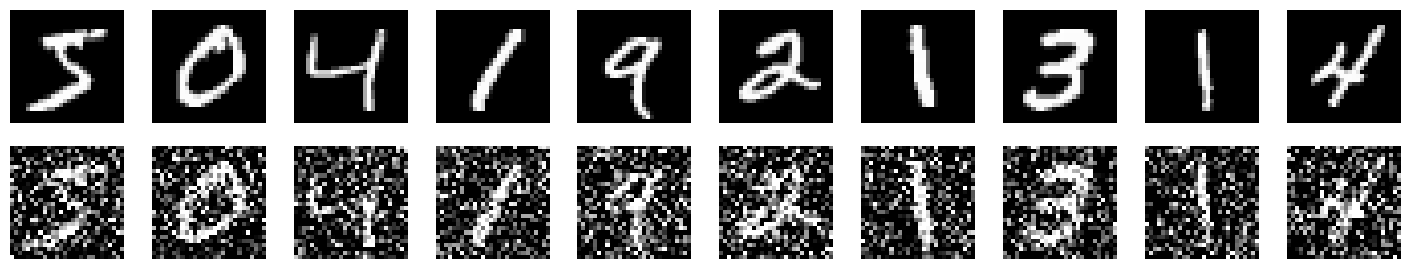

In [20]:
def add_noise(imgs, noise_factor=0.5):
    noisy = imgs + noise_factor * torch.randn_like(imgs)
    return torch.clip(noisy, 0., 1.)

train_imgs = train_dataset.data.unsqueeze(1).float() / 255.0
test_imgs  = test_dataset.data.unsqueeze(1).float() / 255.0

train_noisy = add_noise(train_imgs)
test_noisy  = add_noise(test_imgs)

train_loader = DataLoader(TensorDataset(train_noisy, train_imgs), batch_size=128, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_noisy, test_imgs), batch_size=128, shuffle=False)

# See the images
n = 10
plt.figure(figsize=(18, 5))
for i in range(n):
    # Original clean
    ax = plt.subplot(3, n, i+1)
    plt.imshow(train_imgs[i].squeeze(), cmap='gray')
    ax.axis('off')

    # Noisy
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(train_noisy[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

In [21]:
# ----------------------------
# 2) Autoencoder Model
# ----------------------------
class DenoiseAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28 -> 14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 14 -> 7
            nn.ReLU(),
        )
        # Bottleneck
        self.fc_enc = nn.Linear(64*7*7, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 64*7*7)

        # Decoder
        self.dec = nn.Sequential(
            # (Batch, 64, 7, 7) -> (B, 32, 14, 14)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # (B, 32, 14, 14) -> (B, 1, 28, 28)
            nn.ConvTranspose2d(32, 1,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # required for BCE
        )

    def forward(self, x):
        x = self.enc(x)
        x = x.view(x.size(0), -1)
        x = self.fc_enc(x)

        x = self.fc_dec(x)
        x = x.view(x.size(0), 64, 7, 7)
        x = self.dec(x)
        return x

model = DenoiseAutoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DenoiseAutoencoder(
  (enc): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_enc): Linear(in_features=3136, out_features=128, bias=True)
  (fc_dec): Linear(in_features=128, out_features=3136, bias=True)
  (dec): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [22]:
# ----------------------------
# 3) Training Setup
# ----------------------------
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

epochs = 30
for ep in range(epochs):
    model.train()
    total_loss = 0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(train_loader)
    print(f"Epoch [{ep+1}/{epochs}] Loss: {avg:.4f}")


Epoch [1/30] Loss: 0.1995
Epoch [2/30] Loss: 0.1117
Epoch [3/30] Loss: 0.1032
Epoch [4/30] Loss: 0.0996
Epoch [5/30] Loss: 0.0974
Epoch [6/30] Loss: 0.0960
Epoch [7/30] Loss: 0.0949
Epoch [8/30] Loss: 0.0940
Epoch [9/30] Loss: 0.0934
Epoch [10/30] Loss: 0.0928
Epoch [11/30] Loss: 0.0922
Epoch [12/30] Loss: 0.0918
Epoch [13/30] Loss: 0.0914
Epoch [14/30] Loss: 0.0909
Epoch [15/30] Loss: 0.0906
Epoch [16/30] Loss: 0.0903
Epoch [17/30] Loss: 0.0899
Epoch [18/30] Loss: 0.0896
Epoch [19/30] Loss: 0.0893
Epoch [20/30] Loss: 0.0891
Epoch [21/30] Loss: 0.0888
Epoch [22/30] Loss: 0.0886
Epoch [23/30] Loss: 0.0884
Epoch [24/30] Loss: 0.0881
Epoch [25/30] Loss: 0.0879
Epoch [26/30] Loss: 0.0877
Epoch [27/30] Loss: 0.0875
Epoch [28/30] Loss: 0.0873
Epoch [29/30] Loss: 0.0872
Epoch [30/30] Loss: 0.0870


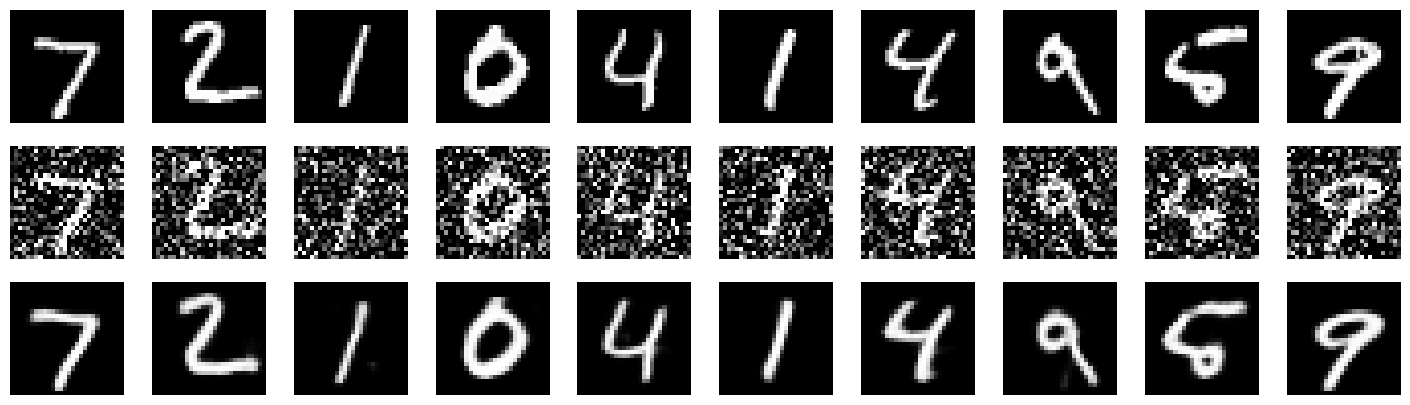

In [23]:

# ----------------------------
# 4) Denoising + Display
# ----------------------------

model.eval()
with torch.no_grad():
    sample_noisy, sample_clean = next(iter(test_loader))
    sample_noisy = sample_noisy.to(device)

    denoised = model(sample_noisy).cpu()

n = 10
plt.figure(figsize=(18, 5))
for i in range(n):
    # Original clean
    ax = plt.subplot(3, n, i+1)
    plt.imshow(sample_clean[i].squeeze(), cmap='gray')
    ax.axis('off')

    # Noisy
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(sample_noisy[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

    # Denoised
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(denoised[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.show()